# 📓 Modelo de OneClassSVM entrenado con 2F de datos Astro, y predicción sobre datos Unid (no identificados)

**Proyecto**: Detección de posibles fuentes de materia oscura usando ML en datos Fermi-LAT  
**Autor**: Marta Canino Romero  
**Fecha**: febrero-mayo 20225

---

## ✨ Descripción:

Este notebook aplica un modelo **One-Class SVM** entrenado con datos de fuentes astrofísicas conocidas (ASTRO) usando las siguientes características:

- E_peak
- beta

Este modelo se entrena para identificar anomalías que puedan corresponder a posibles fuentes de materia oscura (UNIDs) en los datos no identificados del catálogo 4FGL.

---

## 📌 Objetivos específicos:

- Entrenar modelo OCSVM con [número de features] 
- Optimizar hiperparámetros (grid search sobre `nu` y `gamma`)
- Evaluar sobre datos de validación y prueba
- Aplicar modelo final sobre datos UNID para predicción

---

## 🗂️ Entrada de datos:

- `../../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt`

## 💾 Salida esperada:

- Mejor combinación de hiperparámetros
- Métricas de evaluación (f1-score, confusion matrix)
- Exportación de los UNIDs más anómalos


In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score


In [80]:
# Cargar dataset
data_path = "../../data/processed/XY_bal_log_Rel/astro/astro_df.txt"
df_astro = pd.read_csv(data_path, sep='\s+')

df_astro = df_astro.rename(columns={"0,1=astro,DM": "class"})
# --- Comprobamos distribución del dataset ---
print(f" Dataset cargado. Forma: {df_astro.shape}")
print(f" Nombres de las columnas: {list(df_astro.columns)}")

df_astro.head()

 Dataset cargado. Forma: (2831, 5)
 Nombres de las columnas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'astro_DM']


,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),astro_DM
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [81]:
# --- Selección de características ---
features = ['Log(E_peak)', 'Log(beta)']
target = 'astro_DM'

print(f"Features seleccionadas: {features}")
print(f"Columna objetivo: {target}")

# --- Comprobamos valores nulos ---
print("\n Valores faltantes por columna:")
print(df_astro[features + [target]].isnull().sum())

print("\n Muestra del dataset:")
display(df_astro[features + [target]].head())

Features seleccionadas: ['Log(E_peak)', 'Log(beta)']
Columna objetivo: astro_DM

 Valores faltantes por columna:
Log(E_peak)    0
Log(beta)      0
astro_DM       0
dtype: int64

 Muestra del dataset:


,Log(E_peak),Log(beta),astro_DM
0,-0.412502,-1.325139,0.0
1,0.708140,-0.000174,0.0
2,0.224740,-0.581202,0.0
3,0.257319,-0.561933,0.0
4,0.326110,-1.100179,0.0


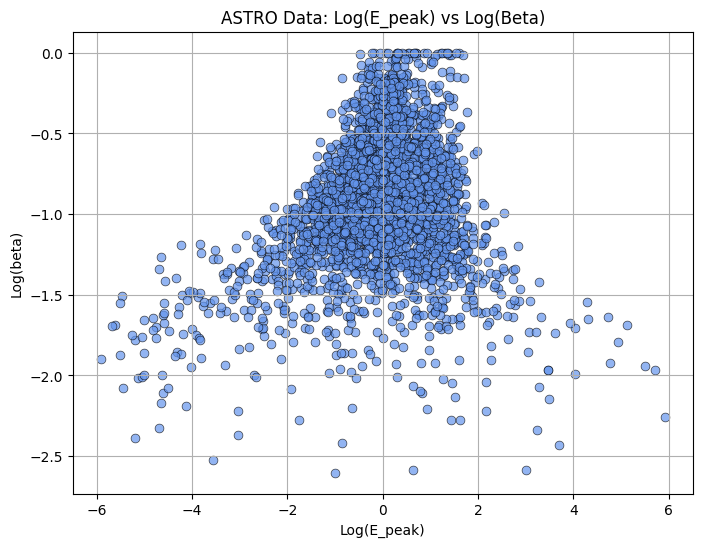

In [82]:
# Comprobamos la distribución de los datos astro antes de escalar
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=df_astro,
    x="Log(E_peak)",
    y="Log(beta)",
    color="cornflowerblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)

plt.title("ASTRO Data: Log(E_peak) vs Log(Beta)")
plt.xlabel("Log(E_peak)")
plt.ylabel("Log(beta)")
plt.grid(True)
plt.show()

In [83]:
X = df_astro[features].values
y = df_astro[target].values

# SPLIT: Train / Val / Test
# 60% train, 20% val, 20% test
# de esta manera, el test set no se ve en el entrenamiento
# y el val set se usa para ajustar los hiperparámetros)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Escalamos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


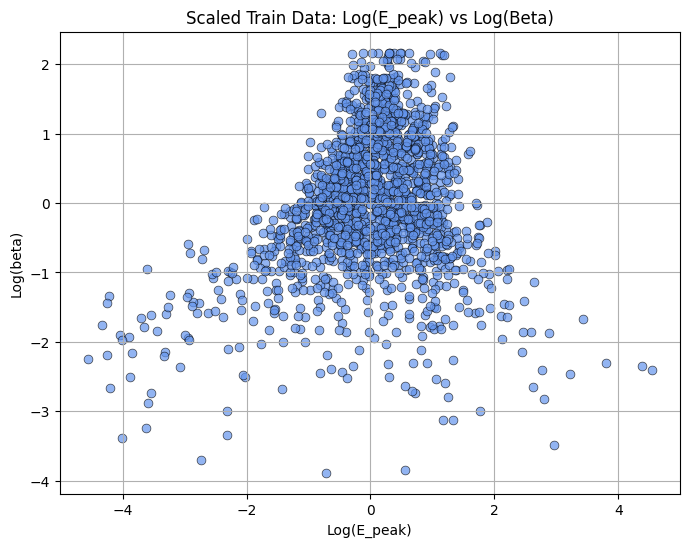

In [84]:
# Comprobamos que los datos están bien escalados
plt.figure(figsize=(8, 6))

sns.scatterplot(
    x=X_train_scaled[:, 0],
    y=X_train_scaled[:, 1],
    color="cornflowerblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)
plt.title("Scaled Train Data: Log(E_peak) vs Log(Beta)")
plt.xlabel("Log(E_peak)")
plt.ylabel("Log(beta)")
plt.grid(True)
plt.show()


In [85]:
# Hiperparámetros a explorar
nu_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]
# gamma_values = ['scale', 'auto'] + list(np.logspace(-4, 2, 7))
# gamma_values = ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10]
gamma_values = ['scale', 'auto'] + list(np.logspace(-3, 1, 5))

# Tracking
results = []
best_outliers = np.inf
best_model = None
best_params = {}

print("Buscando hiperparámetros que minimicen outliers en ASTRO (validación)...")

for nu in nu_values:
    for gamma in gamma_values:
        model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        model.fit(X_train_scaled)

        preds_val = model.predict(X_val_scaled)  # 1 = normal, -1 = outlier
        pred_labels = np.where(preds_val == 1, 0, 1)         # Mapear a 0 = normal, 1 = anomalía
        true_labels = y_val.astype(int)                  # Aseguramos tipo int
        n_outliers = np.sum(preds_val == -1)
        f1 = f1_score(true_labels, pred_labels, pos_label=0)

        results.append({'nu': nu, 'gamma': gamma, 'val_outliers': n_outliers, 'f1_score': f1})

        """
        if f1 > best_score:
            best_score = f1
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}
        """
        if n_outliers < best_outliers:
            best_outliers = n_outliers
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}

# Mostrar resultado óptimo
print(f"\n Mejor combinación de hiperparámetros:")
print(f"   - ν = {best_params['nu']}")
print(f"   - γ = {best_params['gamma']}")
print(f"Outliers (val set): {best_outliers} de {len(X_val_scaled)} muestras")

# Convertir a DataFrame si quieres visualizar todo el grid
df_results = pd.DataFrame(results)
display(df_results.sort_values(by='val_outliers'))

Buscando hiperparámetros que minimicen outliers en ASTRO (validación)...

 Mejor combinación de hiperparámetros:
   - ν = 0.001
   - γ = 0.01
Outliers (val set): 2 de 566 muestras


,nu,gamma,val_outliers,f1_score
3,0.001,0.01,2,0.998230
10,0.002,0.01,2,0.998230
9,0.002,0.001,3,0.997343
4,0.001,0.1,3,0.997343
11,0.002,0.1,3,0.997343
2,0.001,0.001,4,0.996454
18,0.005,0.1,4,0.996454
16,0.005,0.001,5,0.995563
17,0.005,0.01,5,0.995563
23,0.010,0.001,8,0.992883


In [86]:
# Evaluar el modelo en el conjunto de validación
val_preds = best_model.predict(X_val_scaled)
n_val_outliers = np.sum(val_preds == -1)
print(f"Outliers (val set): {n_val_outliers} de {len(X_val_scaled)} muestras")

# Evaluar el modelo en el conjunto de test
# (no se ha visto en el entrenamiento)
test_preds = best_model.predict(X_test_scaled)
n_test_outliers = np.sum(test_preds == -1)
print(f"Outliers (test set): {n_test_outliers} de {len(X_test_scaled)} muestras")

Outliers (val set): 2 de 566 muestras
Outliers (test set): 4 de 567 muestras


<Axes: ylabel='Count'>

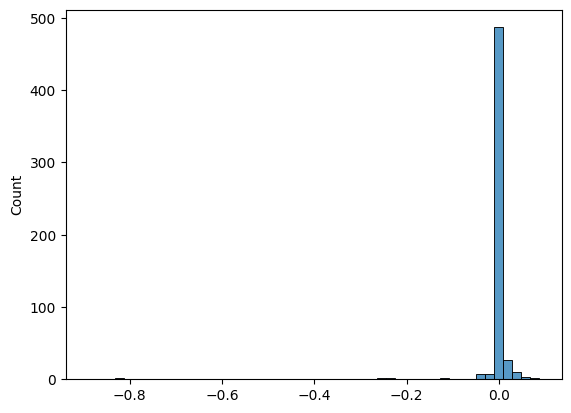

In [87]:
scores = model.decision_function(X_val_scaled)

sns.histplot(scores, bins=50)

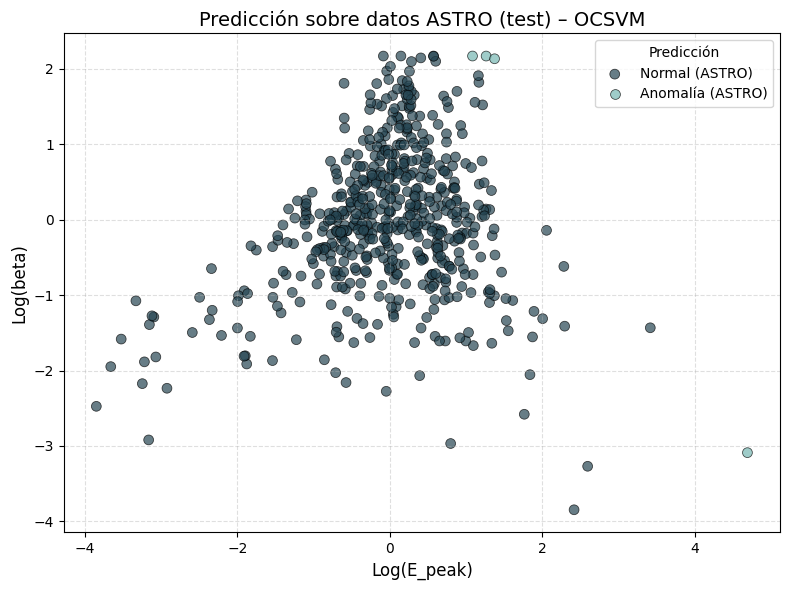

In [89]:
plt.figure(figsize=(8, 6))

# Colores mejorados
palette = {
    1: '#264653',   # ASTRO normal (azul petróleo)
    -1: '#76b7b2'   # ASTRO outlier (azul claro)
}

sns.scatterplot(
    x=X_test_scaled[:, 0],
    y=X_test_scaled[:, 1],
    hue=test_preds,
    palette=palette,
    edgecolor='k',
    alpha=0.7,
    s=50,
    marker='o'
)

plt.title("Predicción sobre datos ASTRO (test) – OCSVM", fontsize=14)
plt.xlabel("Log(E_peak)", fontsize=12)
plt.ylabel("Log(beta)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(
    title="Predicción",
    loc='upper right',
    labels=["Normal (ASTRO)", "Anomalía (ASTRO)"],
    fontsize=10
)
plt.tight_layout()
plt.show()


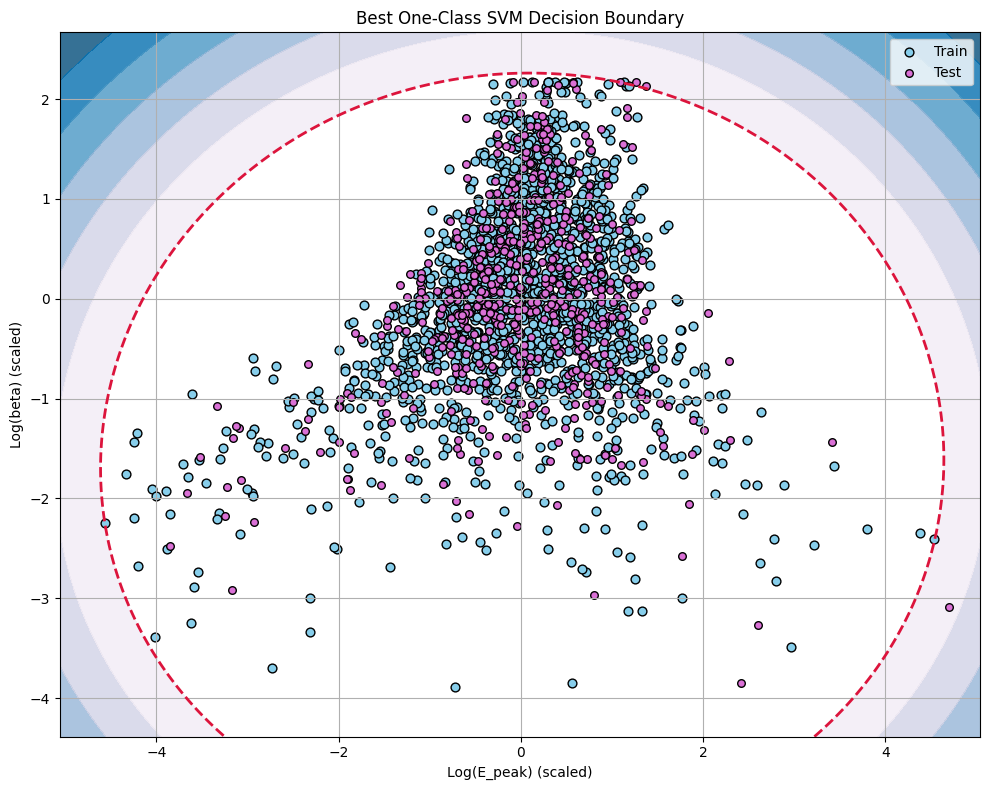

In [90]:
# Create meshgrid (with correct feature order)
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5, 300),  # E_peak
    np.linspace(X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5, 300)   # beta
)

# xx = E_peak
# yy = beta

grid = np.c_[xx.ravel(), yy.ravel()]
Z = best_model.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

# Plot training and test data
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c='skyblue', edgecolors='k', s=40, label='Train')
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c='orchid', edgecolors='k', s=30, label='Test')
# plt.scatter(X_val_scaled[:, 1], X_val_scaled[:, 0], c='magenta', edgecolors='k', s=30, label='Val')

plt.xlabel("Log(E_peak) (scaled)")
plt.ylabel("Log(beta) (scaled)")
plt.title("Best One-Class SVM Decision Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Predict on UNIDs

In [91]:
unids_path = "../../data/raw/unids_3F_beta_err_names.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')
df_unids.head()

,E_peak,beta,sigma_det,beta_Rel,number
0,2.51290,0.0897,7.3996,1.630992,0
1,1.47820,0.4163,5.4150,0.770838,1
2,1.59640,0.6783,10.7909,0.371222,2
3,0.93095,0.2771,7.6056,0.628654,3
4,0.44480,0.3207,4.2748,0.567509,4


In [92]:
# convertimos a logaritmo
cols_to_log = ["E_peak", "beta", "sigma_det", "beta_Rel"]
df_unids_log = df_unids.copy()
df_unids_log[cols_to_log] = df_unids_log[cols_to_log].apply(lambda x: np.log10(x.clip(lower=1e-10)))

In [93]:
# Extraer y escalar 
X_unids_log = df_unids_log[["E_peak", "beta"]].values
X_unids_scaled = scaler.transform(X_unids_log)

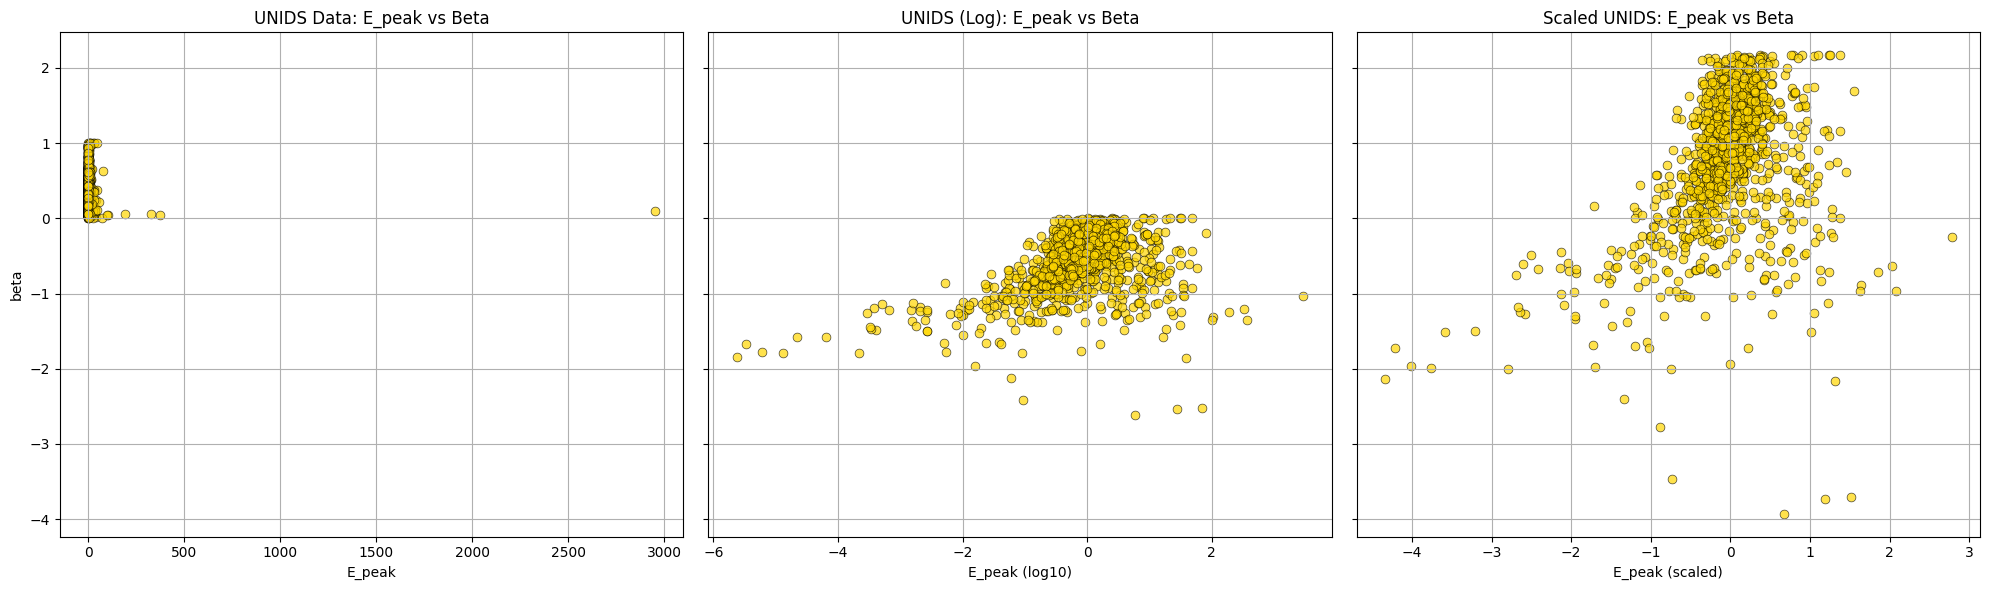

In [94]:
# --- Create subplots ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# --- Plot 1: Raw UNIDS data ---
sns.scatterplot(
    data=df_unids,
    x="E_peak",
    y="beta",
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[0]
)
axes[0].set_title("UNIDS Data: E_peak vs Beta")
axes[0].set_xlabel("E_peak")
axes[0].set_ylabel("beta")
axes[0].grid(True)

# --- Plot 2: Log-transformed UNIDS ---
sns.scatterplot(
    data=df_unids_log,
    x="E_peak",
    y="beta",
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[1]
)
axes[1].set_title("UNIDS (Log): E_peak vs Beta")
axes[1].set_xlabel("E_peak (log10)")
axes[1].set_ylabel("")  # hide repeated ylabel
axes[1].grid(True)

# --- Plot 3: Scaled UNIDS ---
sns.scatterplot(
    x=X_unids_scaled[:, 0],
    y=X_unids_scaled[:, 1],
    color="gold",
    edgecolor='k',
    alpha=0.7,
    s=40,
    ax=axes[2]
)
axes[2].set_title("Scaled UNIDS: E_peak vs Beta")
axes[2].set_xlabel("E_peak (scaled)")
axes[2].set_ylabel("")  # hide repeated ylabel
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [95]:
# Predecir sobre unids usando el mejor modelo
# preds_non_astro = best_model.predict(X_unids_scaled)
unids_preds = best_model.predict(X_unids_scaled)

n_outliers = np.sum(unids_preds == -1)
n_normals = np.sum(unids_preds == 1)

print(f"Predicted ASTRO-like: {n_normals}")
print(f"Predicted not ASTRO-like (anomalies): {n_outliers}")


Predicted ASTRO-like: 1121
Predicted not ASTRO-like (anomalies): 4


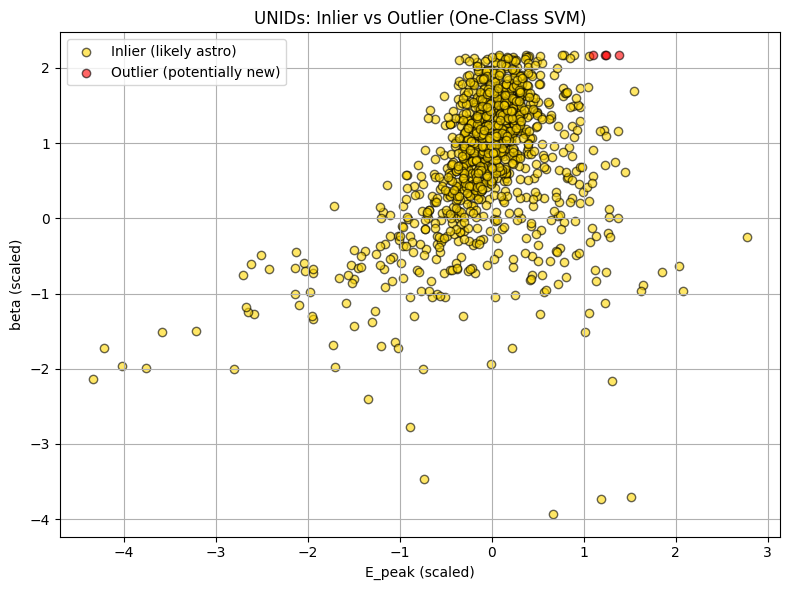

In [96]:
inliers = X_unids_scaled[unids_preds == 1]
outliers = X_unids_scaled[unids_preds == -1]

plt.figure(figsize=(8, 6))
plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', label='Inlier (likely astro)', alpha=0.6)
plt.scatter(outliers[:, 0], outliers[:,1], c='red', edgecolors='k', label='Outlier (potentially new)', alpha=0.6)

plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("UNIDs: Inlier vs Outlier (One-Class SVM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

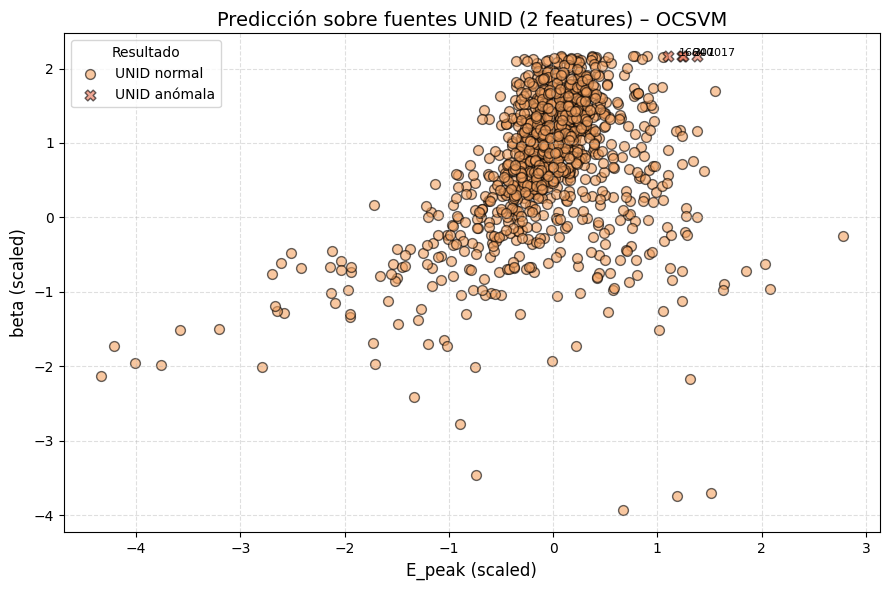

In [97]:
plt.figure(figsize=(9, 6))

# Colores mejorados
color_inlier = '#f4a261'   # unID normal → naranja dorado
color_outlier = '#e76f51'  # unID outlier → rojo intenso

# Plot unID inliers
plt.scatter(inliers[:, 0], inliers[:, 1], c=color_inlier, edgecolors='k',
            label='UNID normal', alpha=0.6, s=50, marker='o')

# Plot unID outliers
plt.scatter(outliers[:, 0], outliers[:, 1], c=color_outlier, edgecolors='k',
            label='UNID anómala', alpha=0.6, s=60, marker='X')

# Anotar top N anomalías por ID
for idx in most_anomalous_idx:
    x = X_unids_scaled[idx, 0]
    y = X_unids_scaled[idx, 1]
    label = int(df_unids_log.loc[idx, 'number'])
    plt.text(x + 0.1, y, str(label), color='black', fontsize=8)

# Etiquetas y estilo
plt.xlabel("E_peak (scaled)", fontsize=12)
plt.ylabel("beta (scaled)", fontsize=12)
plt.title("Predicción sobre fuentes UNID (2 features) – OCSVM", fontsize=14)
plt.legend(title='Resultado', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

plt.savefig("../../outputs/figures/scaled/2F_UNIDs_OneClassSVM_2D_colored.png", dpi=300, bbox_inches='tight')
plt.show()

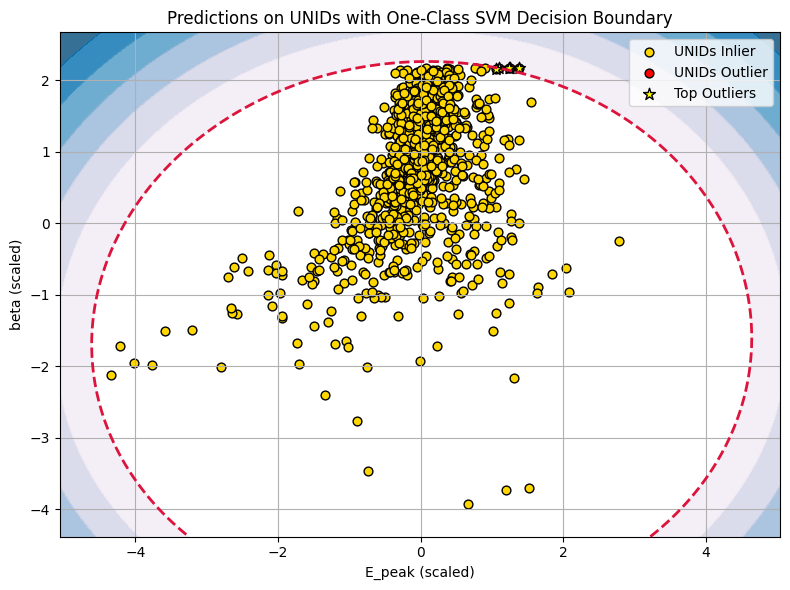

In [98]:
# Create meshgrid (with correct feature order: [beta, E_peak])
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5, 300),  # E_peak
    np.linspace(X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5, 300)   # beta
)

grid = np.c_[xx.ravel(), yy.ravel()]
Z = best_model.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

preds_unids = best_model.predict(X_unids_scaled)
inliers = X_unids_scaled[preds_unids == 1]
outliers = X_unids_scaled[preds_unids == -1]

plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', s=40, label='UNIDs Inlier')
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', s=40, label='UNIDs Outlier')

# Highlight most anomalous UNIDs using their lowest decision score:
decision_scores = best_model.decision_function(X_unids_scaled)
# Optional: mark top 5 most anomalous
top_anomalies = X_unids_scaled[np.argsort(decision_scores)[:5]]
plt.scatter(top_anomalies[:, 0], top_anomalies[:, 1], c='yellow', edgecolors='black', s=80, label='Top Outliers', marker='*')


# Plot training and test data
# plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0], c='skyblue', edgecolors='k', s=40, label='ASTRO (Train)')
# plt.scatter(X_unids_scaled[:, 1], X_unids_scaled[:, 0], c='orchid', edgecolors='k', s=40, label='Test')
# plt.scatter(X_unids_scaled[:, 1], X_unids_scaled[:, 0], c='tomato', edgecolors='k', s=40, label='UNIDs')


plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("Predictions on UNIDs with One-Class SVM Decision Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Anomaly Scoring - UNIDs

In [99]:
# Paso 1: Evaluar cada muestra no identificada con el modelo entrenado
# decision_function devuelve un valor continuo: cuanto más alto, más normal (positivo); cuanto más bajo, más anómalo (negativo)
decision_scores = best_model.decision_function(X_unids_scaled)  # X_unids_scaled = muestras no etiquetadas, ya escaladas

# Paso 2: Predecir si cada punto es inlier (1) o outlier (-1)
unids_preds = best_model.predict(X_unids_scaled)  # 1 = normal, -1 = anomalía

# Paso 3: Agregar los resultados al DataFrame original
df_unids_log["svm_score"] = decision_scores       # Puntaje bruto del modelo (positivo = normal)
df_unids_log["prediction"] = unids_preds          # Clasificación binaria: inlier o outlier

# Paso 4: Invertimos el score para que valores más altos signifiquen más anomalía
# Esto es útil para poder escalar la puntuación y ordenar más intuitivamente
anom_scores = -decision_scores  # Ahora, valores grandes = más anómalos

# Paso 5: Escalamos los scores de anomalía al rango [0, 100] para facilitar su interpretación
anom_percent = MinMaxScaler(feature_range=(0, 100)).fit_transform(anom_scores.reshape(-1, 1)).flatten()

# Guardamos el puntaje invertido y su porcentaje normalizado en el DataFrame
df_unids_log["Anomaly_Score"] = anom_scores
df_unids_log["Anomaly_Rank(%)"] = anom_percent  # 100 = más anómalo, 0 = más normal

# Paso 6: Filtramos solo los puntos predichos como anómalos y los ordenamos por su score más alto
top_anomalies = df_unids_log[df_unids_log["prediction"] == -1] \
                    .sort_values(by="Anomaly_Rank(%)", ascending=False) \
                    .head(10)

# Guardamos los índices (puede ser útil si queremos recuperar sus posiciones originales)
most_anomalous_idx = top_anomalies.index

# Paso 7: Guardamos los 10 más anómalos en un archivo
top_anomalies.to_csv("../../data/processed/unids_most_anomalous_2F.txt", sep="\t", index=False)

# Paso 8: Mostramos en pantalla un resumen de las anomalías detectadas
print("Top Most Anomalous UNID Sources (4F One-Class SVM):")
display(top_anomalies[['E_peak', 'beta', 'number', 'svm_score', 'Anomaly_Score', 'Anomaly_Rank(%)']])


Top Most Anomalous UNID Sources (4F One-Class SVM):


,E_peak,beta,number,svm_score,Anomaly_Score,Anomaly_Rank(%)
1017,1.682984,-0.000087,1017,-0.005415,0.005415,100.000000
307,1.510143,0.000000,307,-0.002774,0.002774,98.583555
240,1.493960,-0.000391,240,-0.002463,0.002463,98.416687
166,1.329194,0.000000,166,-0.000303,0.000303,97.258356


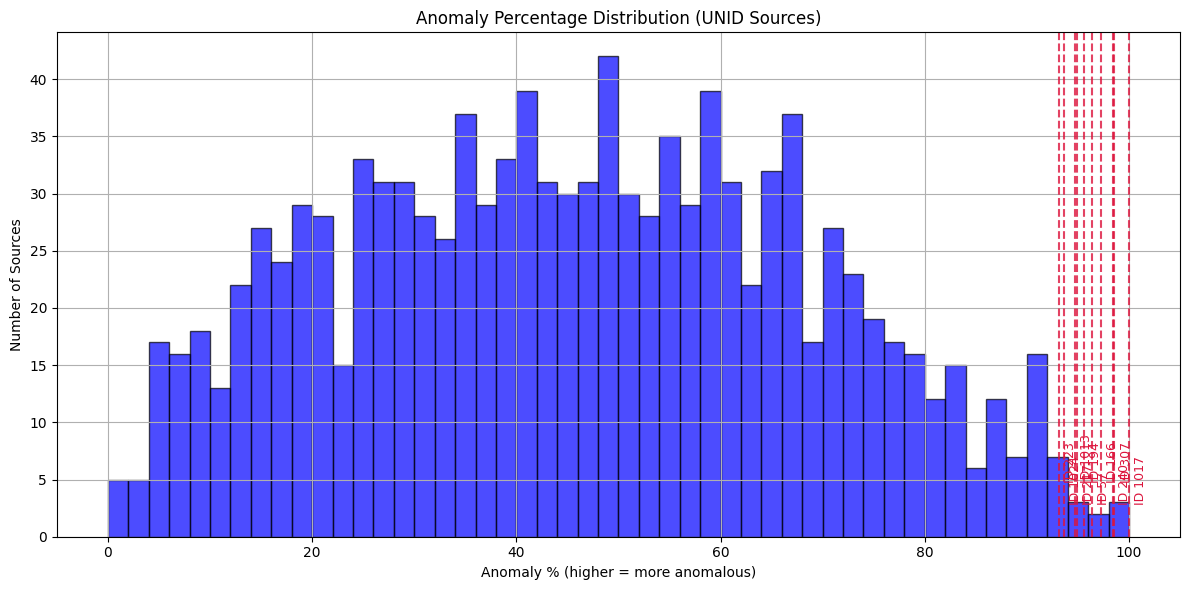

In [100]:
# Sort anomaly scores and grab top N labels
N = 10
sorted_idx = np.argsort(-anom_percent)  # high anomaly % = more anomalous
top_N_idx = sorted_idx[:N]

top_labels = df_unids_log.iloc[top_N_idx]['number'].astype(str).values
top_scores = anom_percent[top_N_idx]

plt.figure(figsize=(12, 6))
plt.hist(anom_percent, bins=50, color='blue', edgecolor='k', alpha=0.7)
plt.title("Anomaly Percentage Distribution (UNID Sources)")
plt.xlabel("Anomaly % (higher = more anomalous)")
plt.ylabel("Number of Sources")

for i in range(N):
    x = top_scores[i]
    label = top_labels[i]
    plt.axvline(x, color='crimson', linestyle='--', alpha=0.8)
    plt.text(x + 0.5, 3 + (i % 2) * 2, f"ID {label}", rotation=90, color='crimson', ha='left', fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()


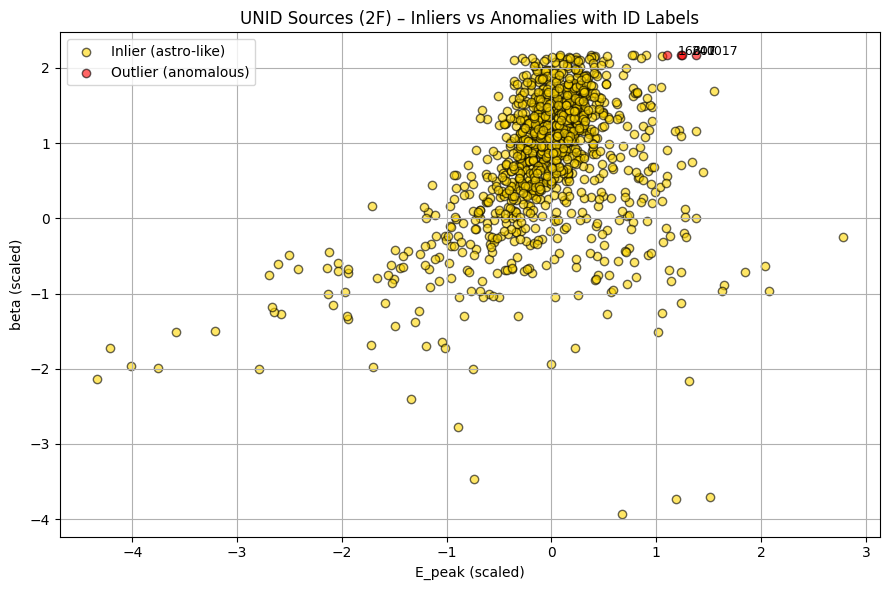

In [101]:
plt.figure(figsize=(9, 6))

# Inliers and outliers from scaled data
inliers = X_unids_scaled[unids_preds == 1]
outliers = X_unids_scaled[unids_preds == -1]

# Plot inliers (gold)
plt.scatter(inliers[:, 0], inliers[:, 1], c='gold', edgecolors='k', label='Inlier (astro-like)', alpha=0.6)

# Plot outliers (red)
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', edgecolors='k', label='Outlier (anomalous)', alpha=0.6)

# Annotate top 10 anomalies by ID
for idx in most_anomalous_idx:
    x = X_unids_scaled[idx, 0]  # E_peak (scaled)
    y = X_unids_scaled[idx, 1]  # beta (scaled)
    label = int(df_unids_log.loc[idx, 'number'])
    plt.text(x + 0.1, y, str(label), color='black', fontsize=9)

# Axis labels and styling
plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("UNID Sources (2F) – Inliers vs Anomalies with ID Labels")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("../../outputs/figures/scaled/2F_UNIDs_OneClassSVM_2D_scaled.png", dpi=300, bbox_inches='tight')

plt.show()


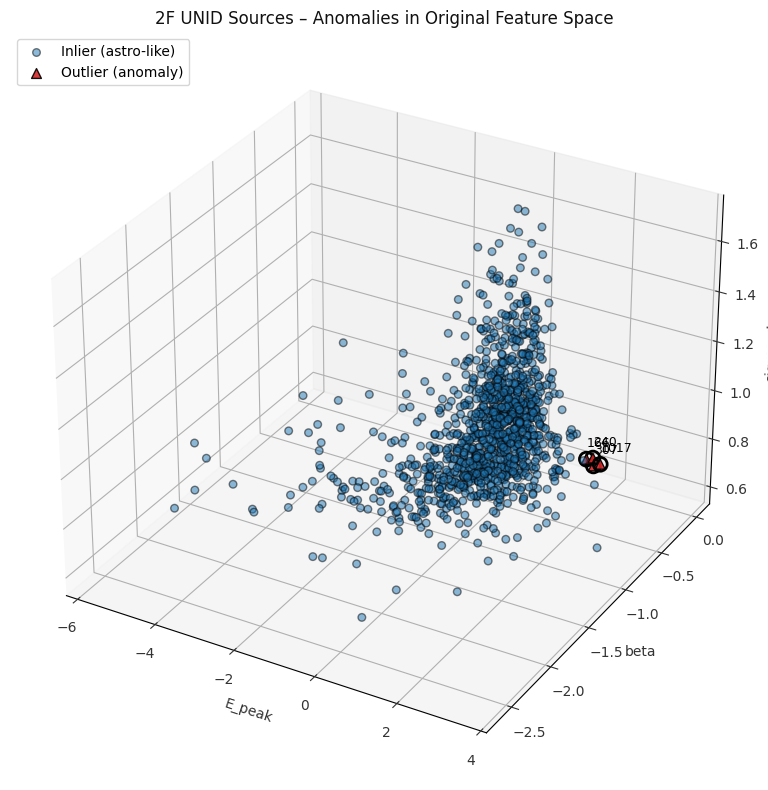

In [102]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Original/log-transformed values for 3 relevant features
x_vals = df_unids_log['E_peak'].values
y_vals = df_unids_log['beta'].values
z_vals = df_unids_log['sigma_det'].values  # or 'beta_Rel' for 3F.2

# Use model predictions for coloring
inlier_idx = df_unids_log['prediction'] == 1
outlier_idx = df_unids_log['prediction'] == -1

# Inliers
ax.scatter(
    x_vals[inlier_idx], y_vals[inlier_idx], z_vals[inlier_idx],
    c='#1f77b4', edgecolor='k', s=30, label='Inlier (astro-like)', alpha=0.5
)

# Outliers
ax.scatter(
    x_vals[outlier_idx], y_vals[outlier_idx], z_vals[outlier_idx],
    c='#d62728', marker='^', edgecolor='k', s=50, label='Outlier (anomaly)', alpha=0.9
)

# Annotate top anomalies
top_anomalies = df_unids_log[df_unids_log['prediction'] == -1].sort_values('Anomaly_Rank(%)', ascending=False).head(10)
for idx in top_anomalies.index:
    ax.scatter(
        x_vals[idx], y_vals[idx], z_vals[idx],
        facecolors='none', edgecolors='black', linewidths=2, s=100
    )
    ax.text(
        x_vals[idx], y_vals[idx], z_vals[idx] + 0.05,
        str(int(df_unids_log.loc[idx, 'number'])),
        color='black', fontsize=9
    )

ax.set_xlabel('E_peak')
ax.set_ylabel('beta')
ax.set_zlabel('sigma_det')  # or 'beta_Rel'
ax.set_title("2F UNID Sources – Anomalies in Original Feature Space")
ax.legend(loc='upper left')

ax.tick_params(colors='#333333')
ax.xaxis.label.set_color('#333333')
ax.yaxis.label.set_color('#333333')
ax.zaxis.label.set_color('#333333')
ax.title.set_color('#111111')
ax.grid(color='#aaaaaa', linestyle='--', alpha=0.3)

plt.savefig("../../outputs/figures/2F_UNIDs_OneClassSVM_og.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# Comparar con UNIDs ANN

In [103]:

# Load unID source data
# unids_path = "../../data/raw/unids_3F_beta_err_names.txt"
unids_3F = np.genfromtxt('../../data/raw/unids_3F_beta_err_names.txt',dtype='str') 
unids_3F_data = np.asarray(unids_3F[1::,:],dtype=float)
unids_log=np.log10(unids_3F_data[:,[0,1]])

# Load unid data with DM proba
ann_unids_path = "../../ANN_original/unids_DM_std_proba_check_repeated_kfold_2F_21.txt"
unids_DM_std_proba_repeated_kfold = np.genfromtxt(ann_unids_path, dtype='str')
print(unids_DM_std_proba_repeated_kfold[0:3])

[['Numb' 'unids_DM_proba_check_repeated_kfold']
 ['0' '4.410883601199984e-11']
 ['1' '0.5128374525851896']]


In [104]:

unids_DM_std_proba_data_repeated_kfold = np.asarray(unids_DM_std_proba_repeated_kfold[1:], dtype=float)

N_unids=unids_log.shape[0]
N_splits = 5
N_Repeats = 2
N_sample = N_splits * N_Repeats

unids_number = unids_DM_std_proba_data_repeated_kfold[0:N_unids, 0]

unids_DM_std_proba_N_sample_repeated_kfold = np.zeros((N_unids, N_sample + 1))
unids_DM_std_proba_N_sample_repeated_kfold[:, 0] = unids_number.astype(int)
unids_DM_std_proba_N_sample_repeated_kfold[:, 1:(N_sample+1)] = np.reshape(
    unids_DM_std_proba_data_repeated_kfold[:, 1], (N_unids, N_sample))

unids_mean = unids_DM_std_proba_N_sample_repeated_kfold[:, 1:(N_sample+1)].mean(axis=1)
unids_std = unids_DM_std_proba_N_sample_repeated_kfold[:, 1:(N_sample+1)].std(axis=1, ddof=1)

df_ann = pd.DataFrame({
    'unid_idx': unids_number.astype(int),
    'ann_mean_prob': unids_mean,
    'ann_std_prob': unids_std
})

df_ann.to_csv('ann_probs_per_unid.csv', index=False)

df_ann.head()


,unid_idx,ann_mean_prob,ann_std_prob
0,0,0.244647,0.265055
1,1,0.185154,0.268088
2,2,0.301971,0.379135
3,3,0.396568,0.290201
4,4,0.352528,0.297019


In [105]:

print('df_unids colummns: ', df_unids_log.columns)
print('df_ann columns: ', df_ann.columns)

print("Total unIDs ann:", len(df_ann))
print("Total unIDs ocsvm:", len(df_unids_log))
print("High ANN prob (≥0.9):", (df_ann['ann_mean_prob'] >= 0.9).sum())
print("High ANN prob (≥0.5):", (df_ann['ann_mean_prob'] >= 0.5).sum())

print("Predicted anomalies (OCSVM):", (df_unids_log['prediction'] == -1).sum())
print("Anomaly rank ≥95%:", (df_unids_log['Anomaly_Rank(%)'] >= 95).sum())

# Is this true?
set(df_ann['unid_idx']) == set(df_unids_log['number'].astype(int))

# ensure UNID ID types from both datasets match
df_unids_log["unid_idx"] = df_unids_log["number"].astype(int)

# Merge ANN and OCSVM results
df_combined = pd.merge(df_unids_log, df_ann, on="unid_idx", how="inner")

# Optional: sort by ANN prob or anomaly percent
# df_combined_sorted = df_combined.sort_values(by=["ann_mean_prob", "Anomaly_Rank(%)"], ascending=[False, False])
# another shot: only filter on anomaly, then sort by ANN prob
df_combined[df_combined["Anomaly_Rank(%)"] >= 95].sort_values(by="ann_mean_prob", ascending=False).head(10)


df_unids colummns:  Index(['E_peak', 'beta', 'sigma_det', 'beta_Rel', 'number', 'svm_score',
       'prediction', 'Anomaly_Score', 'Anomaly_Rank(%)'],
      dtype='object')
df_ann columns:  Index(['unid_idx', 'ann_mean_prob', 'ann_std_prob'], dtype='object')
Total unIDs ann: 1125
Total unIDs ocsvm: 1125
High ANN prob (≥0.9): 0
High ANN prob (≥0.5): 4
Predicted anomalies (OCSVM): 4
Anomaly rank ≥95%: 6


,E_peak,beta,sigma_det,beta_Rel,number,svm_score,prediction,Anomaly_Score,Anomaly_Rank(%),unid_idx,ann_mean_prob,ann_std_prob
194,1.065916,-0.000695,0.731436,-1.319877,194,0.002856,1,-0.002856,95.563466,194,0.384020,0.168682
307,1.510143,0.000000,0.617263,-3.045757,307,-0.002774,-1,0.002774,98.583555,307,0.357062,0.198370
240,1.493960,-0.000391,0.649860,-1.279450,240,-0.002463,-1,0.002463,98.416687,240,0.333237,0.186204
57,1.264133,-0.003883,0.629042,-0.818293,57,0.001274,1,-0.001274,96.412218,57,0.322650,0.270549
1017,1.682984,-0.000087,0.632690,-1.191027,1017,-0.005415,-1,0.005415,100.000000,1017,0.311443,0.305182
166,1.329194,0.000000,0.637159,-2.420216,166,-0.000303,-1,0.000303,97.258356,166,0.257563,0.225955


In [106]:
# Define thresholds
p_cut = 0.4
anom_cut = 80

# Filter: high probability and high anomaly
top_candidates = df_combined[
    (df_combined["ann_mean_prob"] >= p_cut) &
    (df_combined["Anomaly_Rank(%)"] >= anom_cut)
]

# Sort by anomaly strength
top_candidates = top_candidates.sort_values(by="Anomaly_Rank(%)", ascending=False).head(10)

# Save or display
# top_candidates.to_csv("../../data/processed/unids_ann_ocsvm_top_combined.csv", index=False)

print("Top UNIDs by ANN and OCSVM agreement:")
display(top_candidates[["unid_idx", "E_peak", "beta", "ann_mean_prob", "Anomaly_Rank(%)", "Anomaly_Score"]])

Top UNIDs by ANN and OCSVM agreement:


,unid_idx,E_peak,beta,ann_mean_prob,Anomaly_Rank(%),Anomaly_Score
774,774,0.108633,-0.049635,0.421578,87.582403,-0.017736
802,802,0.052155,-0.050074,0.422792,87.522463,-0.017848
93,93,-0.271792,-0.080242,0.420176,84.634947,-0.023231
1099,1099,0.014058,-0.111652,0.414235,81.172362,-0.029687


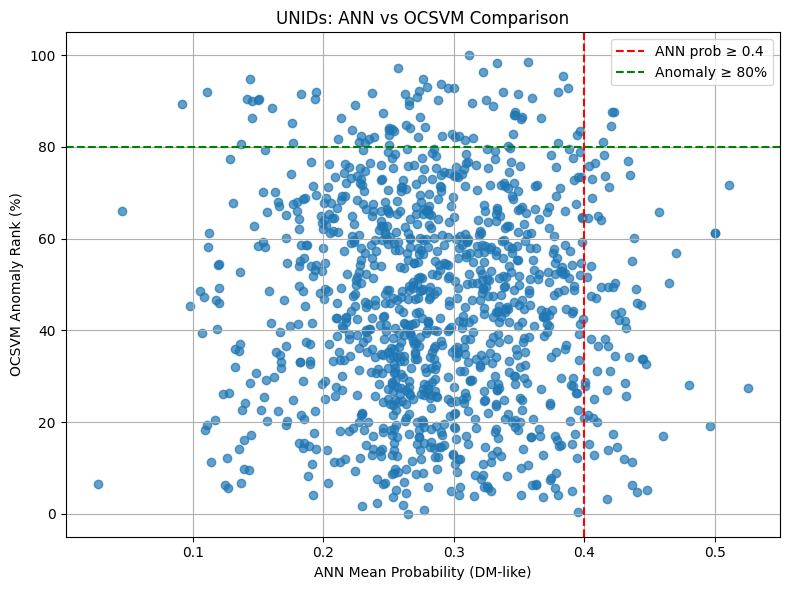

In [107]:
plt.figure(figsize=(8,6))
plt.scatter(df_combined["ann_mean_prob"], df_combined["Anomaly_Rank(%)"], alpha=0.7)
plt.axvline(p_cut, color='r', linestyle='--', label=f"ANN prob ≥ {p_cut}")
plt.axhline(anom_cut, color='g', linestyle='--', label=f"Anomaly ≥ {anom_cut}%")
plt.xlabel("ANN Mean Probability (DM-like)")
plt.ylabel("OCSVM Anomaly Rank (%)")
plt.title("UNIDs: ANN vs OCSVM Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()